## Lab 3. Detección de Malware

### Miembros
* Fernanda Esquivel - 21542
* Andrés Montoya - 21552

### Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/SDS-Lab-04)

# Creación del dataset

In [1911]:
import os
import pandas as pd
import numpy as np
import pefile
import hashlib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from datetime import datetime
import shutil
import subprocess
warnings.filterwarnings('ignore')

### 0. Desempaquetar los archivos

In [1912]:
unpacked_dir = "unpacked/"

In [1913]:
# 0. Desempaquetar los archivos
def check_if_packed(file_path):
    print("\nAnalyzing file: ", os.path.basename(file_path))
    print("=" * 50)
    # known packers
    suspicious_sections = ['.UPX', 'UPX', '.pak', 'pec2', '.ASPack', '.adata']
    pe = pefile.PE(file_path)
    counter = 0
    for section in pe.sections:
        print(section.Name, 
              hex(section.VirtualAddress), 
              hex(section.Misc_VirtualSize), 
              section.SizeOfRawData)
        
        section_name = section.Name.decode().rstrip('\x00')
        if any(sus in section_name for sus in suspicious_sections):
            counter += 1
    if counter > 0:
        return True
    else:
        return False

def unpackFile(file_path):
    subprocess.run([r"C:\Users\monto\OneDrive\Documents\UVG\Malware\upx-5.0.0-win64\upx-5.0.0-win64\upx.exe", "-d", file_path, "-o", os.path.join(unpacked_dir, os.path.basename(file_path))])

In [1914]:
if not os.path.exists(unpacked_dir):
    os.makedirs(unpacked_dir)

    for file in os.listdir("malwr/MALWR"):
        file_path = os.path.join("malwr/MALWR/", file)
        if check_if_packed(file_path):
            print("File is packed, unpacking...")
            unpackFile(file_path)
        else:
            shutil.copy(file_path, unpacked_dir)

In [1915]:
# 1. Creación del dataset mediante análisis estático (enfocado)
def getFileHash(file_path):
    """Calcular el hash MD5 de un archivo."""
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

In [1916]:
def getPEFeatures(file_path):
    """Extraer características estáticas clave de un archivo PE."""
    features = {}
    
    # Metadatos básicos del archivo
    features['file_name'] = os.path.basename(file_path)
    features['file_size'] = os.path.getsize(file_path)
    features['md5'] = getFileHash(file_path)
    
    try:
        pe = pefile.PE(file_path)
        
        #Secciones
        section_names = []
        section_entropies = []
        
        if hasattr(pe, 'sections'):
            for section in pe.sections:
                name = section.Name.decode('utf-8', 'ignore').strip('\x00')
                section_names.append(name)
                
                #Calcular entropía de la sección
                entropy = 0
                if len(section.get_data()) > 0:
                    byte_counts = {}
                    for byte in section.get_data():
                        if isinstance(byte, int):  # Para Python 3
                            byte_counts[byte] = byte_counts.get(byte, 0) + 1
                        else:  # Para Python 2
                            byte_counts[ord(byte)] = byte_counts.get(ord(byte), 0) + 1
                    
                    for count in byte_counts.values():
                        probability = float(count) / len(section.get_data())
                        entropy -= probability * np.log2(probability)
                
                section_entropies.append(entropy)
        
        features['section_names'] = '|'.join(section_names)
        features['number_of_sections'] = len(section_names)
        
        #DLLs y funciones utilizadas
        imported_dlls = []
        imported_functions_count = 0
        
        if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
            for entry in pe.DIRECTORY_ENTRY_IMPORT:
                dll_name = entry.dll.decode('utf-8', 'ignore')
                imported_dlls.append(dll_name.lower())
                imported_functions_count += len(entry.imports)
        
        features['imported_dlls'] = '|'.join(imported_dlls)
        features['imported_dlls_count'] = len(imported_dlls)
        features['imported_functions_count'] = imported_functions_count
        
        #Detección de DLLs sospechosas
        suspicious_dlls = ['ws2_32.dll', 'wininet.dll', 'urlmon.dll', 'shell32.dll', 'advapi32.dll']
        suspicious_dll_count = sum(1 for dll in imported_dlls if dll.lower() in suspicious_dlls)
        features['suspicious_dll_count'] = suspicious_dll_count
        
        #Fecha de compilación
        if hasattr(pe, 'FILE_HEADER'):
            timestamp = pe.FILE_HEADER.TimeDateStamp
            try:
                compile_date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')
                features['compile_date'] = compile_date
                
                #Antigüedad del ejecutable (en días desde la fecha actual)
                days_since_compile = (datetime.now() - datetime.fromtimestamp(timestamp)).days
                features['days_since_compile'] = days_since_compile
            except:
                #Los timestamps son inválidos
                features['compile_date'] = 'Invalid'
                features['days_since_compile'] = -1
        
        #Entropía general del archivo
        if hasattr(pe, 'sections'):
            # Entropía promedio de todas las secciones
            features['avg_entropy'] = np.mean(section_entropies) if section_entropies else 0
            features['max_entropy'] = max(section_entropies) if section_entropies else 0
        
        #Características adicionales
        #Tipo de archivo
        features['is_dll'] = 1 if pe.is_dll() else 0
        features['is_exe'] = 1 if pe.is_exe() else 0
        
        #Arquitectura
        features['is_32bit'] = 1 if pe.FILE_HEADER.Machine == 0x14c else 0
        features['is_64bit'] = 1 if pe.FILE_HEADER.Machine == 0x8664 else 0
        
        #Liberar recursos
        pe.close()
    
    except Exception as e:
        #Si hay algún error, devolver características básicas solamente
        features['parse_error'] = str(e)
        features['is_packed'] = -1  # Desconocido
        features['number_of_sections'] = -1
        features['imported_dlls_count'] = -1
        features['imported_functions_count'] = -1
        features['compile_date'] = 'Unknown'
        features['days_since_compile'] = -1
        features['avg_entropy'] = -1
        features['max_entropy'] = -1
        features['is_dll'] = -1
        features['is_exe'] = -1
        features['is_32bit'] = -1
        features['is_64bit'] = -1
        features['suspicious_dll_count'] = -1
    
    return features

In [1917]:
def createMalwareDataset(malware_directory):
    """Crear un dataset a partir de archivos de malware en un directorio."""
    data = []
    files = []
    
    #Obtener todos los archivos en el directorio recursivamente
    for root, dirs, filenames in os.walk(malware_directory):
        for filename in filenames:
            file_path = os.path.join(root, filename)
            files.append(file_path)
    
    print(f"Encontrados {len(files)} archivos para analizar.")
    
    #Procesar cada archivo
    for i, file_path in enumerate(files):
        try:
            features = getPEFeatures(file_path)
            data.append(features)
            if (i + 1) % 100 == 0:
                print(f"Procesados {i + 1} archivos...")
        except Exception as e:
            print(f"Error en archivo {file_path}: {str(e)}")
    
    #Crear DataFrame
    df = pd.DataFrame(data)
    return df

In [1918]:
malware_directory = "unpacked/"

#Crear el dataset
df = createMalwareDataset(malware_directory)
print(f"Dataset creado con {df.shape[0]} filas y {df.shape[1]} columnas.")

#Guardar el dataset bruto
df.to_csv("datasets/malware_dataset_raw.csv", index=False)
print("Dataset bruto guardado como 'datasets/malware_dataset_raw.csv'")

Encontrados 40 archivos para analizar.
Dataset creado con 40 filas y 17 columnas.
Dataset bruto guardado como 'datasets/malware_dataset_raw.csv'


# Exploración y pre-procesamiento de datos

## Carga del dataset

In [1919]:
df = pd.read_csv('datasets/malware_dataset_raw.csv')
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")

Dataset cargado con 40 filas y 17 columnas.


In [1920]:
#Eliminar la primera fila
df = df.iloc[1:].reset_index(drop=True)
print(f"Dataset después de eliminar la primera fila: {df.shape[0]} filas y {df.shape[1]} columnas.")

Dataset después de eliminar la primera fila: 39 filas y 17 columnas.


## Exploración básica del dataset

In [1921]:
print("\nInformación básica del dataset:")
print(df.info())


Información básica del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   file_name                 39 non-null     object 
 1   file_size                 39 non-null     int64  
 2   md5                       39 non-null     object 
 3   section_names             39 non-null     object 
 4   number_of_sections        39 non-null     int64  
 5   imported_dlls             39 non-null     object 
 6   imported_dlls_count       39 non-null     int64  
 7   imported_functions_count  39 non-null     int64  
 8   suspicious_dll_count      39 non-null     int64  
 9   compile_date              39 non-null     object 
 10  days_since_compile        39 non-null     int64  
 11  avg_entropy               39 non-null     float64
 12  max_entropy               39 non-null     float64
 13  is_dll                    39 non-n

In [1922]:
print("\nEstadísticas descriptivas para columnas numéricas:")
print(df.describe())


Estadísticas descriptivas para columnas numéricas:
           file_size  number_of_sections  imported_dlls_count  \
count      39.000000           39.000000            39.000000   
mean   154479.589744            3.794872             5.897436   
std    288073.100699            0.522115             1.535456   
min      7168.000000            3.000000             4.000000   
25%      8192.000000            3.500000             5.000000   
50%      8192.000000            4.000000             5.000000   
75%     17408.000000            4.000000             7.000000   
max    762880.000000            5.000000             9.000000   

       imported_functions_count  suspicious_dll_count  days_since_compile  \
count                 39.000000             39.000000           39.000000   
mean                 104.230769              2.307692         5467.230769   
std                   74.309616              0.950176          403.593103   
min                   51.000000              1.000000 

In [1923]:
#Verificar valores nulos
print("\nValores nulos por columna:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Valores nulos por columna:
Series([], dtype: int64)


## Visualizaciones básicas

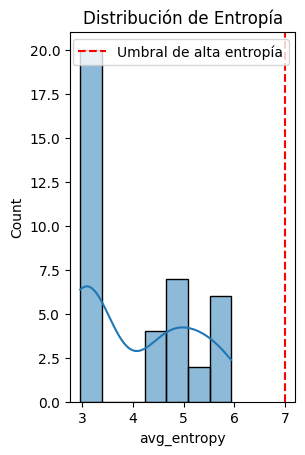

In [1924]:
plt.subplot(1, 2, 2)
sns.histplot(df['avg_entropy'].dropna(), kde=True)
plt.axvline(x=7.0, color='r', linestyle='--', label='Umbral de alta entropía')
plt.title('Distribución de Entropía')
plt.legend()

## Preprocesamiento

In [1925]:
#Seleccionar solo características numéricas
numerical_features = ['file_size', 'number_of_sections', 'imported_dlls_count', 
                    'imported_functions_count', 'days_since_compile', 'avg_entropy', 
                    'max_entropy', 'suspicious_dll_count']

In [1926]:
#Manejar valores faltantes con la mediana
df_numerical = df[numerical_features].copy()
df_numerical = df_numerical.fillna(df_numerical.median())

In [1927]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_numerical),
    columns=df_numerical.columns
)

In [1928]:
df_boolean = df[['is_dll', 'is_exe']].copy()
df_boolean = df_boolean.fillna(df_boolean.mode().iloc[0])

In [1929]:
all_dlls = set()
for dlls_str in df['imported_dlls']:
    if dlls_str: 
        dlls = dlls_str.split('|')
        all_dlls.update(dlls)

dll_dict = {f'dll_{dll}': [] for dll in all_dlls}

for dlls_str in df['imported_dlls']:
    if dlls_str:
        dlls = set(dlls_str.split('|'))
        for dll in all_dlls:
            dll_dict[f'dll_{dll}'].append(1 if dll in dlls else 0)
    else:
        for dll in all_dlls:
            dll_dict[f'dll_{dll}'].append(0)

In [1930]:
dll_dummies = pd.DataFrame(dll_dict)

df_with_dlls = pd.concat([df.drop('imported_dlls', axis=1), dll_dummies], axis=1)

In [1931]:
df_clean = pd.concat([df_scaled, df_boolean, dll_dummies], axis=1)

In [1932]:
print(f"Dataset limpio con {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas.")
print("Columnas seleccionadas:", numerical_features)

Dataset limpio con 39 filas y 21 columnas.
Columnas seleccionadas: ['file_size', 'number_of_sections', 'imported_dlls_count', 'imported_functions_count', 'days_since_compile', 'avg_entropy', 'max_entropy', 'suspicious_dll_count']


In [1933]:
df_clean.to_csv('datasets/malware_dataset_clean.csv', index=False)

In [1934]:
print("\nPreprocesamiento completado. Dataset guardado:")
print("* malware_dataset_clean.csv: Dataset limpio con características numéricas")


Preprocesamiento completado. Dataset guardado:
* malware_dataset_clean.csv: Dataset limpio con características numéricas


# Implementación del modelo

In [1935]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.cm as cm

In [1936]:
#Carga del dataset limpio
df_clean = pd.read_csv('datasets/malware_dataset_clean.csv')
print(f"Dataset cargado con {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas")

Dataset cargado con 39 filas y 21 columnas


In [1937]:
binary_cols = [col for col in df_clean.columns if col not in numerical_features]

In [1938]:
#Escalar las características
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(df_clean[numerical_features])
X_numeric_df = pd.DataFrame(X_numeric_scaled, columns=numerical_features)

X_binary_df = df_clean[binary_cols]
X_df = pd.concat([X_numeric_df, X_binary_df], axis=1)
X_scaled = X_df.values

## Funciones

In [1939]:
#Función para visualizar el método del codo
def plotElbowMethod(X, max_k=10, title="Método del Codo para K-means"):
    inertias = []
    K_range = range(1, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inercia')
    plt.title(title)
    plt.grid(True)
    plt.show()
    
    return inertias

In [1940]:
#Función para visualizar la silueta detallada para un k específico
def plotSilhouetteAnalysis(X, kmeans_opt, agglomerative_opt):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # K-means
    kmeans = KMeans(n_clusters=kmeans_opt, random_state=42, n_init=10)
    cluster_labels_kmeans = kmeans.fit_predict(X)
    silhouette_avg_kmeans = silhouette_score(X, cluster_labels_kmeans)
    sample_silhouette_values_kmeans = silhouette_samples(X, cluster_labels_kmeans)
    
    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=agglomerative_opt)
    cluster_labels_agg = agg.fit_predict(X)
    silhouette_avg_agg = silhouette_score(X, cluster_labels_agg)
    sample_silhouette_values_agg = silhouette_samples(X, cluster_labels_agg)
    
    # Plot K-means silhouette
    y_lower = 10
    for i in range(kmeans_opt):
        ith_cluster_silhouette_values = sample_silhouette_values_kmeans[cluster_labels_kmeans == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / kmeans_opt)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title(f"Análisis de Silhouette para K-means (k={kmeans_opt})")
    ax1.set_xlabel("Coeficiente de Silhouette")
    ax1.set_ylabel("Etiqueta del Cluster")
    ax1.axvline(x=silhouette_avg_kmeans, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    
    # Plot Agglomerative silhouette
    y_lower = 10
    for i in range(agglomerative_opt):
        ith_cluster_silhouette_values = sample_silhouette_values_agg[cluster_labels_agg == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / agglomerative_opt)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax2.set_title(f"Análisis de Silhouette para Agglomerative (k={agglomerative_opt})")
    ax2.set_xlabel("Coeficiente de Silhouette")
    ax2.set_ylabel("Etiqueta del Cluster")
    ax2.axvline(x=silhouette_avg_agg, color="red", linestyle="--")
    ax2.set_yticks([])
    ax2.set_xlim([-0.1, 1])
    
    plt.tight_layout()
    plt.show()
    
    return silhouette_avg_kmeans, silhouette_avg_agg

In [1941]:
#Función para visualizar el dendrograma (para Agglomerative Clustering)
def plotDendrogram(X, max_d=None):
    # Crear un dendrograma
    linked = linkage(X, 'ward')
    
    plt.figure(figsize=(12, 8))
    dendrogram(linked,
                orientation='top',
                distance_sort='descending',
                show_leaf_counts=True,
                truncate_mode='level', 
                p=5)
    
    if max_d:
        plt.axhline(y=max_d, c='k', linestyle='--', label=f'Distancia de corte = {max_d}')
        plt.legend()
    
    plt.title('Dendrograma Jerárquico')
    plt.xlabel('Muestras')
    plt.ylabel('Distancia')
    plt.show()

In [1942]:
#Función para visualizar resultados de clustering
def plotClusteringResults(X, k_kmeans, k_agg):
    # Crear nuevos modelos con los k óptimos
    kmeans = KMeans(n_clusters=k_kmeans, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    
    agg = AgglomerativeClustering(n_clusters=k_agg)
    agg_labels = agg.fit_predict(X)
    
    # Aplicar PCA para visualizar en 2D
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Visualizar resultados
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # K-means
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.8)
    ax1.set_title(f'Clusters K-means (k={k_kmeans})')
    ax1.set_xlabel('Componente Principal 1')
    ax1.set_ylabel('Componente Principal 2')
    legend1 = ax1.legend(*scatter1.legend_elements(), title="Clusters")
    ax1.add_artist(legend1)
    
    # Agglomerative
    scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis', s=50, alpha=0.8)
    ax2.set_title(f'Clusters Agglomerative (k={k_agg})')
    ax2.set_xlabel('Componente Principal 1')
    ax2.set_ylabel('Componente Principal 2')
    legend2 = ax2.legend(*scatter2.legend_elements(), title="Clusters")
    ax2.add_artist(legend2)
    
    plt.tight_layout()
    plt.show()
    
    return kmeans_labels, agg_labels

## Método del codo


Aplicación del método del codo para K-means:


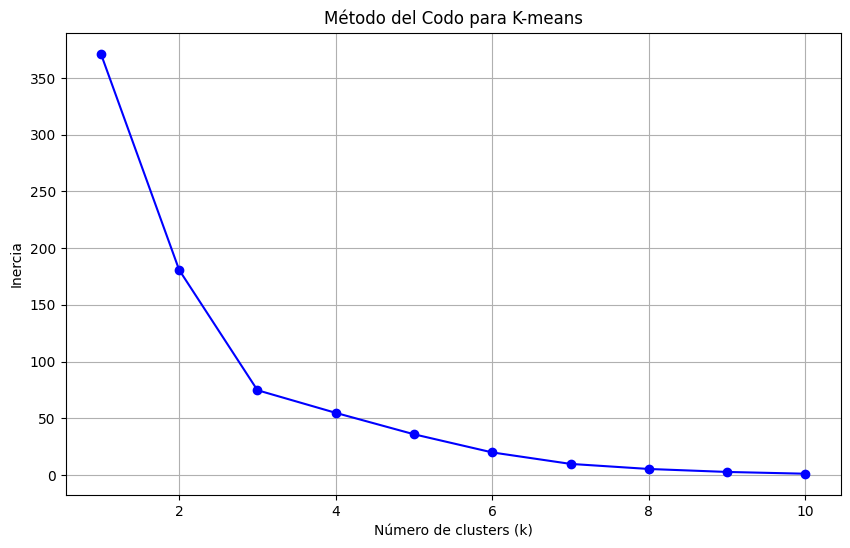

In [2099]:
#Aplicar el método del codo para K-means
print("\nAplicación del método del codo para K-means:")
inertias = plotElbowMethod(X_scaled, max_k=10)

El método del codo muestra un valor optimo al rededor de los 4 clusters.

In [2156]:
kmeans_opt = 4

## Dendograma


Visualización del dendrograma para Agglomerative Clustering:


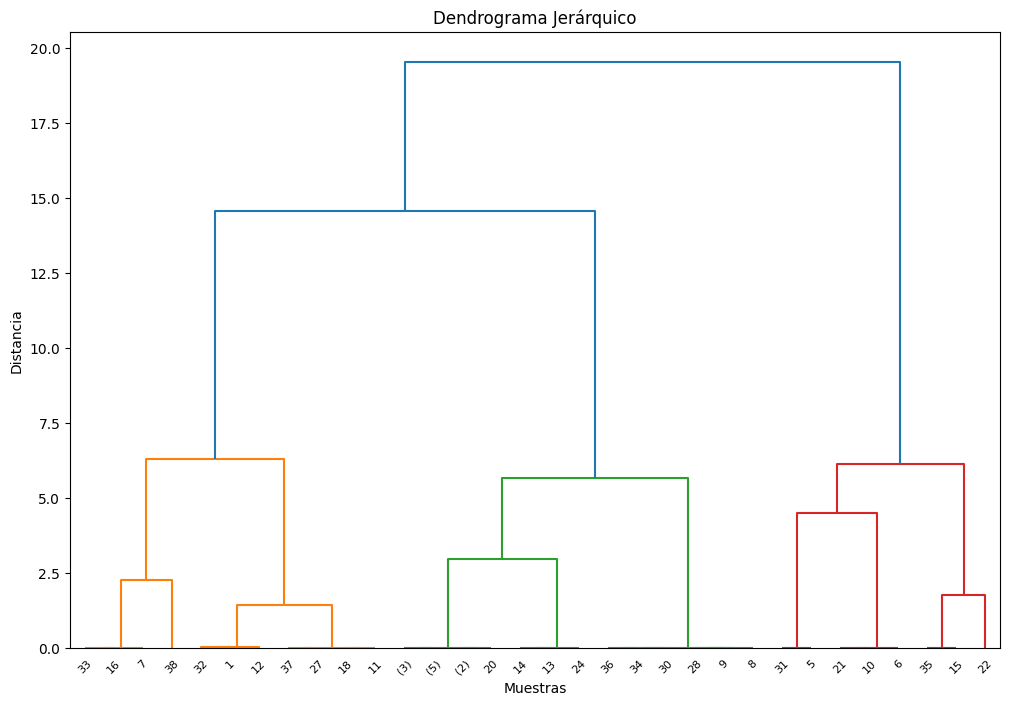

In [2157]:
print("\nVisualización del dendrograma para Agglomerative Clustering:")
plotDendrogram(X_scaled)

El metodo de aglomeración tambien muestra un numero optimo de 4 clusters

In [2158]:
agglomerative_opt = 4

## Análisis de Silhouette para los k óptimos


Análisis detallado de Silhouette para los k óptimos:


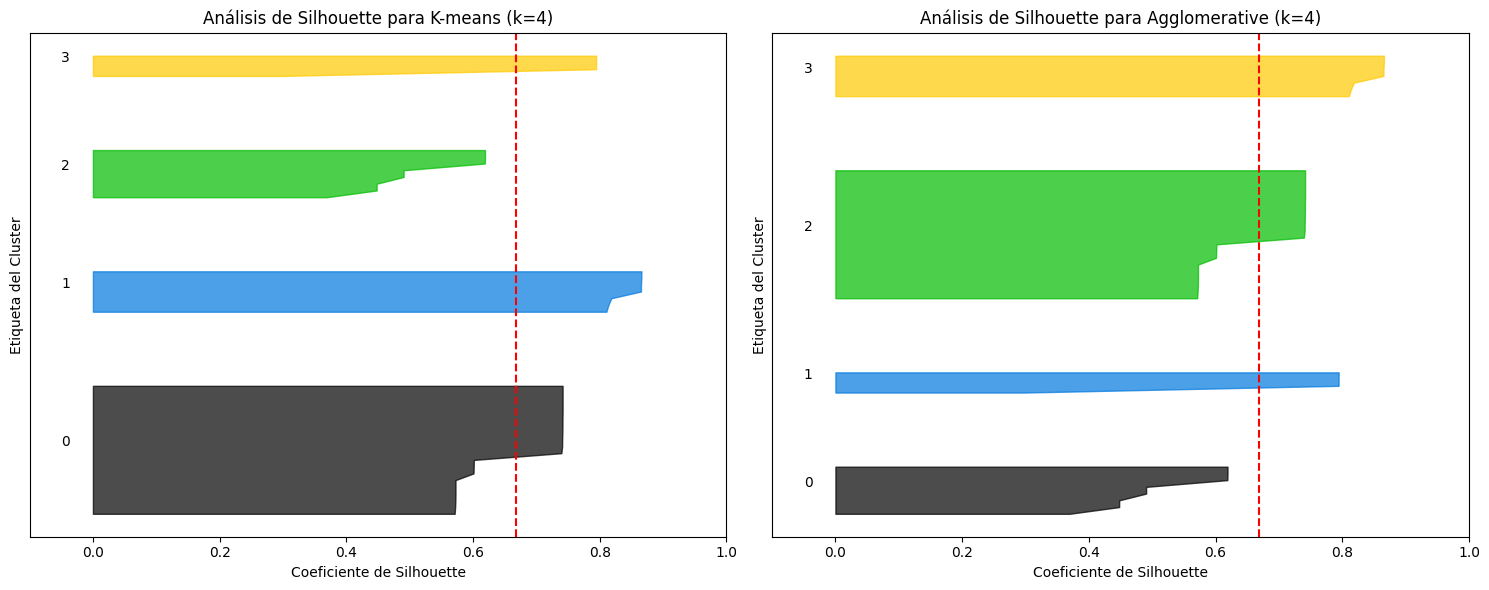

Coeficiente de Silhouette para K-means (k=4): 0.6684
Coeficiente de Silhouette para Agglomerative (k=4): 0.6684


In [2159]:
print("\nAnálisis detallado de Silhouette para los k óptimos:")
sil_kmeans, sil_agg = plotSilhouetteAnalysis(X_scaled, kmeans_opt, agglomerative_opt)
print(f"Coeficiente de Silhouette para K-means (k={kmeans_opt}): {sil_kmeans:.4f}")
print(f"Coeficiente de Silhouette para Agglomerative (k={agglomerative_opt}): {sil_agg:.4f}")

Se puede observar que el coeficiente se encuentra en 0.6988, lo cual indica una buena separación entre clusters

## Clustering


Visualición de resultados de clustering:


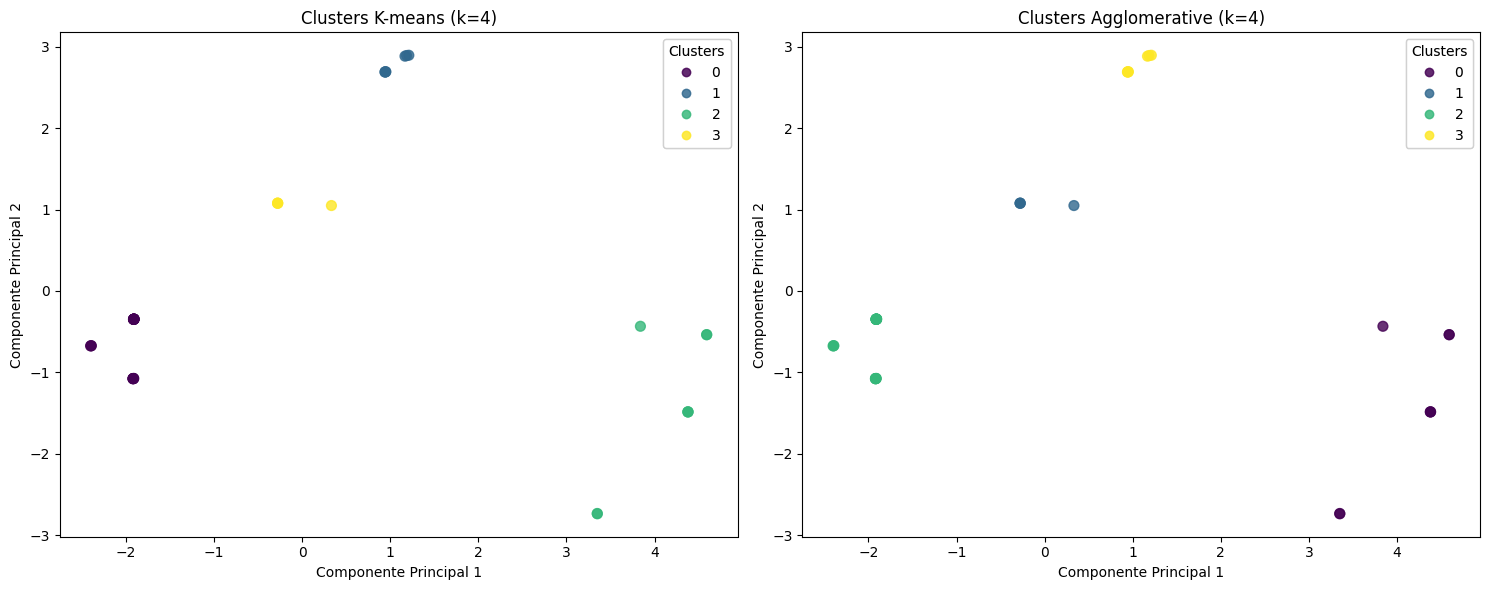

In [2160]:
print("\nVisualición de resultados de clustering:")
kmeans_labels, agg_labels = plotClusteringResults(X_scaled, kmeans_opt, agglomerative_opt)

In [2161]:
#Agregar etiquetas de cluster al dataset original
df_results = df_clean.copy()
df_results['kmeans_cluster'] = kmeans_labels
df_results['agg_cluster'] = agg_labels

In [2162]:
#Guardar resultados
df_results.to_csv('datasets/malware_clustering_results.csv', index=False)
print("\nResultados guardados en 'datasets/malware_clustering_results.csv'")


Resultados guardados en 'datasets/malware_clustering_results.csv'


In [2163]:
#Análisis de características por cluster
print("\nAnálisis de características por cluster")

# Para K-means
print("Análisis de clusters K-means:")
kmeans_cluster_analysis = df_results.groupby('kmeans_cluster').agg({
    'file_size': 'mean',
    'number_of_sections': 'mean',
    'imported_dlls_count': 'mean',
    'imported_functions_count': 'mean',
    'avg_entropy': 'mean',
    'max_entropy': 'mean',
    'is_dll': 'sum',
    'is_exe': 'sum',
    'suspicious_dll_count': 'mean',
    'file_size': 'count'  # Conteo de archivos por cluster
}).rename(columns={'file_size': 'count'})

print(kmeans_cluster_analysis)


Análisis de características por cluster
Análisis de clusters K-means:
                count  number_of_sections  imported_dlls_count  \
kmeans_cluster                                                   
0                  20            0.398015            -0.790052   
1                   7           -1.542308             0.727456   
2                   8            0.155475             1.552189   
3                   4            0.398015            -0.427169   

                imported_functions_count  avg_entropy  max_entropy  is_dll  \
kmeans_cluster                                                               
0                              -0.620727    -0.921386    -0.781518       0   
1                              -0.262176     0.736183     0.302420       0   
2                               1.942983     1.477170     1.745285       5   
3                              -0.323525     0.364268    -0.112215       0   

                is_exe  suspicious_dll_count  
kmeans_cluster  

In [2164]:
#Para Agglomerative
print("\nAnálisis de clusters Agglomerative:")
agg_cluster_analysis = df_results.groupby('agg_cluster').agg({
    'file_size': 'mean',
    'number_of_sections': 'mean',
    'imported_dlls_count': 'mean',
    'imported_functions_count': 'mean',
    'avg_entropy': 'mean',
    'max_entropy': 'mean',
    'is_dll': 'sum',
    'is_exe': 'sum',
    'suspicious_dll_count': 'mean',
    'file_size': 'count'  # Conteo de archivos por cluster
}).rename(columns={'file_size': 'count'})

print(agg_cluster_analysis)


Análisis de clusters Agglomerative:
             count  number_of_sections  imported_dlls_count  \
agg_cluster                                                   
0                8            0.155475             1.552189   
1                4            0.398015            -0.427169   
2               20            0.398015            -0.790052   
3                7           -1.542308             0.727456   

             imported_functions_count  avg_entropy  max_entropy  is_dll  \
agg_cluster                                                               
0                            1.942983     1.477170     1.745285       5   
1                           -0.323525     0.364268    -0.112215       0   
2                           -0.620727    -0.921386    -0.781518       0   
3                           -0.262176     0.736183     0.302420       0   

             is_exe  suspicious_dll_count  
agg_cluster                                
0                 3             -0.328060  
1

## Comparación de los algoritmos

In [2165]:
#Matriz de confusión entre los dos algoritmos
print("\nComparación entre clasificaciones de K-means y Agglomerative:")
confusion_matrix = pd.crosstab(df_results['kmeans_cluster'], df_results['agg_cluster'], 
                                rownames=['K-means'], colnames=['Agglomerative'])
print(confusion_matrix)


Comparación entre clasificaciones de K-means y Agglomerative:
Agglomerative  0  1   2  3
K-means                   
0              0  0  20  0
1              0  0   0  7
2              8  0   0  0
3              0  4   0  0


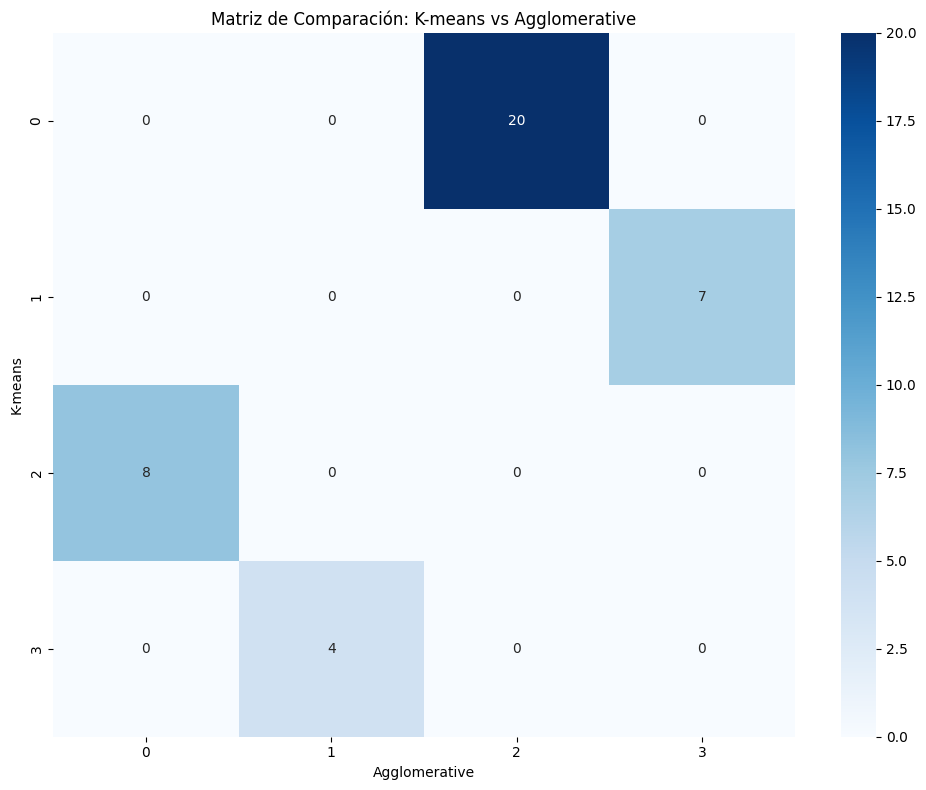

In [2166]:
#Heatmap de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Comparación: K-means vs Agglomerative')
plt.tight_layout()
plt.show()

In [2167]:
#Análisis de la diferencia en asignación de clusters
print("\nAnálisis de diferencia en asignación de clusters:")
df_results['same_cluster'] = df_results['kmeans_cluster'] == df_results['agg_cluster']
agreement_percentage = df_results['same_cluster'].mean() * 100
print(f"Porcentaje de acuerdo entre K-means y Agglomerative: {agreement_percentage:.2f}%")


Análisis de diferencia en asignación de clusters:
Porcentaje de acuerdo entre K-means y Agglomerative: 0.00%


In [2168]:
#Características de muestras que difieren en la asignación de clusters
different_samples = df_results[~df_results['same_cluster']]
if len(different_samples) > 0:
    print(f"\nCaracterísticas promedio de muestras con diferente asignación ({len(different_samples)} muestras):")
    print(different_samples[numerical_features].mean())
    
    print("\nCaracterísticas promedio de muestras con la misma asignación:")
    print(df_results[df_results['same_cluster']][numerical_features].mean())
else:
    print("No hay muestras con diferente asignación.")



Características promedio de muestras con diferente asignación (39 muestras):
file_size                  -4.127752e-17
number_of_sections          3.287968e-16
imported_dlls_count        -2.103019e-16
imported_functions_count    1.281027e-16
days_since_compile         -6.946011e-16
avg_entropy                -5.821554e-16
max_entropy                 6.369549e-16
suspicious_dll_count        1.907306e-16
dtype: float64

Características promedio de muestras con la misma asignación:
file_size                  NaN
number_of_sections         NaN
imported_dlls_count        NaN
imported_functions_count   NaN
days_since_compile         NaN
avg_entropy                NaN
max_entropy                NaN
suspicious_dll_count       NaN
dtype: float64


## Creación de modelo

In [2169]:
from dotenv import load_dotenv
import google.generativeai as genai

In [2170]:
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)
embeddings_path = 'datasets/embeddings.csv'

In [2171]:
def prepare_text_features(df):
    return df.apply(lambda row: f"""
    Archivo con tamaño {row['file_size']} bytes, 
    con {row['number_of_sections']} secciones, 
    {row['imported_dlls_count']} DLLs importadas,
    {row['imported_functions_count']} funciones importadas,
    {row['days_since_compile']} días desde compilación,
    entropía promedio de {row['avg_entropy']:.2f},
    entropía máxima de {row['max_entropy']:.2f},
    {'es DLL' if row['is_dll'] else 'no es DLL'},
    {'es EXE' if row['is_exe'] else 'no es EXE'},
    con {row['suspicious_dll_count']} DLLs sospechosas
    """, axis=1)

In [2172]:
def get_embeddings(texts):
    print("Getting embeddings...")
    if os.path.exists(embeddings_path):
        print("Embeddings already exist, loading from file...")
        existing_embeddings = pd.read_csv(embeddings_path)
        #return a numpy array
        return np.array(existing_embeddings)

    print("No embeddings found, generating new ones...")
    model = 'models/embedding-001'
    embeddings = []
    
    for text in texts:
        result = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")
        embeddings.append(result['embedding'])
    
    #save embeddings to csv
    pd.DataFrame(embeddings).to_csv(embeddings_path, index=False)
    return np.array(embeddings)

Getting embeddings...
Embeddings already exist, loading from file...


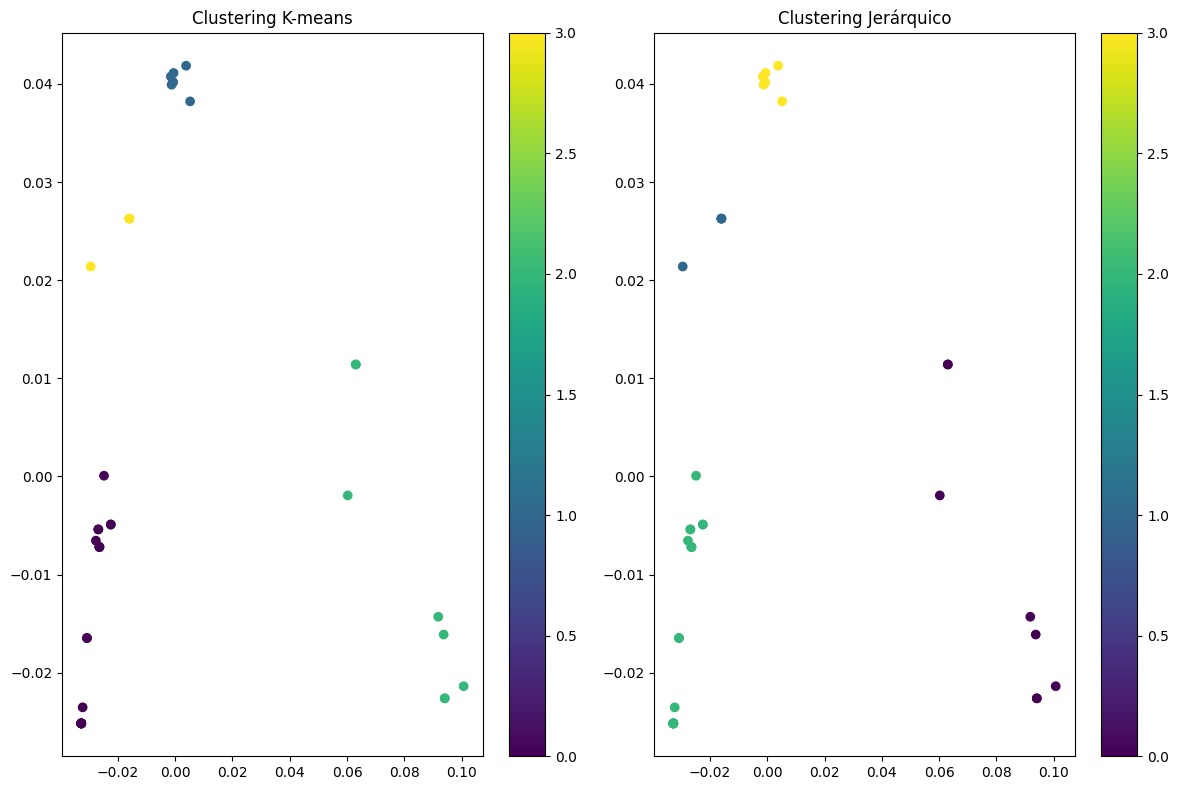

In [2173]:
df = pd.read_csv('datasets/malware_clustering_results.csv')
    
#preparar textos para embeddings
texts = prepare_text_features(df)

#obtener embeddings
embeddings = get_embeddings(texts)

#reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
    
plt.figure(figsize=(12, 8))

#graficar clusters de K-means
plt.subplot(1, 2, 1)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                        c=df['kmeans_cluster'], cmap='viridis')
plt.title('Clustering K-means')
plt.colorbar(scatter)

#graficar clusters jerárquicos
plt.subplot(1, 2, 2)
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                        c=df['agg_cluster'], cmap='viridis')
plt.title('Clustering Jerárquico')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

## Análisis de similitud

In [2174]:
from tqdm import tqdm
import networkx as nx

In [2175]:
#borrar el contenido del output
output_folder = 'jaccard_analysis'
os.system(f'rm -rf {output_folder}/*')

0

In [2176]:
df_similarity = pd.read_csv('datasets/malware_clustering_results.csv').drop(columns=['agg_cluster'])

In [2177]:
def jaccard_similarity(sample1, sample2):
    #seleccionar columnas de DLLs
    dll_columns = [col for col in sample1.index if col.startswith('dll_')]
    
    #convertir a sets
    set1 = {dll for dll in dll_columns if sample1[dll] == 1}
    set2 = {dll for dll in dll_columns if sample2[dll] == 1}
    
    #intersección y unión
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    #evitar división por cero
    if union == 0:
        return 0
    
    return intersection / union

In [2178]:
def generate_jaccard_matrix(df):
    n_samples = df.shape[0]
    jaccard_matrix = np.zeros((n_samples, n_samples))
    
    for i in tqdm(range(n_samples), desc="Calculando matriz de similitud"):
        for j in range(i, n_samples):
            if i == j:
                jaccard_matrix[i, j] = 1.0
            else:
                sim = jaccard_similarity(df.iloc[i], df.iloc[j])
                jaccard_matrix[i, j] = sim
                jaccard_matrix[j, i] = sim  # Matriz simétrica
    
    return jaccard_matrix

In [2179]:
def generate_similarity_graph(jaccard_matrix, threshold, node_labels=None):
    G = nx.Graph()
    
    #agregar nodos
    n_nodes = jaccard_matrix.shape[0]
    for i in range(n_nodes):
        G.add_node(i, label=node_labels[i] if node_labels else i)
    
    #agregar aristas
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            if jaccard_matrix[i, j] >= threshold:
                G.add_edge(i, j, weight=jaccard_matrix[i, j])
    
    return G

In [2180]:
def plot_similarity_graph(G, cluster_labels, threshold, title=None, figsize=(12, 10)):
    plt.figure(figsize=figsize)
    
    #posicionar los nodos
    pos = nx.spring_layout(G, seed=42)
    
    #definir colores por cluster
    unique_clusters = sorted(set(cluster_labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}
    
    #dibujar nodos con colores según su cluster
    for cluster in unique_clusters:
        node_list = [node for node, label in enumerate(cluster_labels) if label == cluster]
        nx.draw_networkx_nodes(G, pos, 
                              nodelist=node_list,
                              node_color=[color_map[cluster]],
                              node_size=100,
                              alpha=0.8,
                              label=f"Cluster {cluster}")
    
    #dibujar aristas
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    plt.legend()
    plt.title(title or f"Grafo de Similitud (umbral = {threshold})")
    plt.axis("off")
    plt.tight_layout()
    
    return plt

In [2181]:
def analyze_graph(G, cluster_labels):
    analysis = {}
    
    #número de nodos y aristas
    analysis['num_nodes'] = G.number_of_nodes()
    analysis['num_edges'] = G.number_of_edges()
    
    #densidad del grafo
    analysis['density'] = nx.density(G)
    
    #componentes conectados
    connected_components = list(nx.connected_components(G))
    analysis['num_connected_components'] = len(connected_components)
    
    #tamaño del componente más grande
    largest_cc = max(connected_components, key=len)
    analysis['largest_component_size'] = len(largest_cc)
    analysis['largest_component_percentage'] = len(largest_cc) / G.number_of_nodes()
    
    #cohesión dentro de los clusters
    cluster_cohesion = {}
    for cluster in set(cluster_labels):
        #nodos de este cluster
        cluster_nodes = [i for i, label in enumerate(cluster_labels) if label == cluster]
        
        if len(cluster_nodes) <= 1:
            cluster_cohesion[cluster] = 0
            continue
            
        #subgrafo inducido por este cluster
        cluster_subgraph = G.subgraph(cluster_nodes)
        
        #densidad del subgrafo (medida de cohesión)
        cluster_cohesion[cluster] = nx.density(cluster_subgraph)
    
    analysis['cluster_cohesion'] = cluster_cohesion
    
    return analysis

In [2182]:
def malware_similarity_analysis(df, thresholds=[0.3, 0.5, 0.7], output_dir="jaccard_analysis"):
    os.makedirs(output_dir, exist_ok=True)
    
    #extraer etiquetas de cluster
    cluster_labels = df['kmeans_cluster'].values
    
    #calcular matriz de similitud Jaccard
    print("Calculando matriz de similitud Jaccard...")
    jaccard_matrix = generate_jaccard_matrix(df)
    
    #guardar heatmap de la matriz de similitud
    plt.figure(figsize=(12, 10))
    sns.heatmap(jaccard_matrix, cmap="YlGnBu")
    plt.title("Matriz de Similitud Jaccard entre muestras de malware")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/jaccard_matrix_heatmap.png")
    plt.close()
    
    #análisis para cada umbral
    for threshold in thresholds:
        print(f"\nAnalizando con umbral de similitud: {threshold}")
        
        #generar grafo global
        print("Generando grafo global...")
        global_graph = generate_similarity_graph(jaccard_matrix, threshold)
        plot_similarity_graph(global_graph, cluster_labels, threshold, 
                             title=f"Grafo Global de Similitud (umbral = {threshold})")
        plt.savefig(f"{output_dir}/global_graph_threshold_{threshold:.1f}.png")
        plt.close()
        
        #análisis del grafo global
        global_metrics = analyze_graph(global_graph, cluster_labels)
        print(f"Métricas del grafo global (umbral = {threshold}):")
        print(f"  - Nodos: {global_metrics['num_nodes']}")
        print(f"  - Aristas: {global_metrics['num_edges']}")
        print(f"  - Densidad: {global_metrics['density']:.4f}")
        print(f"  - Componentes conectados: {global_metrics['num_connected_components']}")
        print(f"  - Tamaño del componente más grande: {global_metrics['largest_component_size']} "
              f"({global_metrics['largest_component_percentage']:.2%} del total)")
        
    print("Generando grafos por familia...")
    for cluster in sorted(set(cluster_labels)):
        #extraer indices de las muestras del cluster
        cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
        
        if len(cluster_indices) <= 1:
            print(f"  Cluster {cluster} tiene solo {len(cluster_indices)} muestra(s), no se genera grafo")
            continue
            
        #extraer submatriz de similitud para el cluster
        cluster_matrix = jaccard_matrix[np.ix_(cluster_indices, cluster_indices)]
        
        #generar grafo para el cluster
        cluster_graph = generate_similarity_graph(cluster_matrix, threshold)
        cluster_labels_subset = [cluster] * len(cluster_indices)
        
        #plot
        plot_similarity_graph(cluster_graph, cluster_labels_subset, threshold,
                                title=f"Similitud en Familia {cluster} (umbral = {threshold})")
        plt.savefig(f"{output_dir}/family_{cluster}_graph_threshold_{threshold:.1f}.png")
        plt.close()
        
        #análisis de la familia
        cluster_metrics = analyze_graph(cluster_graph, cluster_labels_subset)
        print(f"  Métricas de la familia {cluster} (umbral = {threshold}):")
        print(f"    - Muestras: {len(cluster_indices)}")
        print(f"    - Aristas: {cluster_metrics['num_edges']}")
        print(f"    - Densidad: {cluster_metrics['density']:.4f}")
        print(f"    - Cohesión interna: {cluster_metrics['cluster_cohesion'][cluster]:.4f}")
    
    print("\nAnálisis completado. Resultados guardados en", output_dir)
    
    return jaccard_matrix

In [2183]:
malware_similarity_analysis(df_similarity, thresholds=[0.4, 0.65, 0.8])

Calculando matriz de similitud Jaccard...


Calculando matriz de similitud: 100%|██████████| 39/39 [00:00<00:00, 955.53it/s]



Analizando con umbral de similitud: 0.4
Generando grafo global...
Métricas del grafo global (umbral = 0.4):
  - Nodos: 39
  - Aristas: 717
  - Densidad: 0.9676
  - Componentes conectados: 1
  - Tamaño del componente más grande: 39 (100.00% del total)

Analizando con umbral de similitud: 0.65
Generando grafo global...
Métricas del grafo global (umbral = 0.65):
  - Nodos: 39
  - Aristas: 416
  - Densidad: 0.5614
  - Componentes conectados: 2
  - Tamaño del componente más grande: 31 (79.49% del total)

Analizando con umbral de similitud: 0.8
Generando grafo global...
Métricas del grafo global (umbral = 0.8):
  - Nodos: 39
  - Aristas: 240
  - Densidad: 0.3239
  - Componentes conectados: 4
  - Tamaño del componente más grande: 20 (51.28% del total)
Generando grafos por familia...
  Métricas de la familia 0 (umbral = 0.8):
    - Muestras: 20
    - Aristas: 190
    - Densidad: 1.0000
    - Cohesión interna: 1.0000
  Métricas de la familia 1 (umbral = 0.8):
    - Muestras: 7
    - Aristas: 2

array([[1.        , 0.71428571, 1.        , ..., 0.8       , 0.71428571,
        0.57142857],
       [0.71428571, 1.        , 0.71428571, ..., 0.57142857, 1.        ,
        0.85714286],
       [1.        , 0.71428571, 1.        , ..., 0.8       , 0.71428571,
        0.57142857],
       ...,
       [0.8       , 0.57142857, 0.8       , ..., 1.        , 0.57142857,
        0.66666667],
       [0.71428571, 1.        , 0.71428571, ..., 0.57142857, 1.        ,
        0.85714286],
       [0.57142857, 0.85714286, 0.57142857, ..., 0.66666667, 0.85714286,
        1.        ]])

# Conclusiones

### Para ambos algoritmos, ¿para qué número de clústeres se obtiene el coeficiente de Silhouette más alto?

* Para K-means el coeficiente de Silhouette más alto se obtuvo con 4 clusters, con un valor de 0.6684.
* Para Clustering Aglomerativo también se obtuvo el coeficiente más alto con 4 clusters, con un valor idéntico de 0.6684.

Este valor relativamente alto (cercano a 0.7) indica una buena separación entre los clusters y cohesión dentro de ellos, lo que sugiere que la división en 4 familias de malware es apropiada.

### Para ambos algoritmos, ¿En qué medida coincide el coeficiente de Silhouette con el método del codo?

* **Método del codo**: Muestra un punto de inflexión visible alrededor de k=4, donde la inercia comienza a estabilizarse. Esto sugiere que agregar más clusters más allá de este punto proporciona rendimientos decrecientes
* **Coeficiente de Silhouette**: Alcanza su valor máximo en k=4 (0.6684), reforzando la conclusión del método del codo.
* **Dendrograma jerárquico**: También apoya la división en 4 clusters, mostrando 4 ramas principales.

### Según los resultados obtenidos de ambos algoritmos ¿Cuántas familias cree que existen entre los ejemplares de malware proporcionados?

Basado en el análisis, existen **4 familias** distintas de malware en el conjunto de datos:
* Familia 0 (Cluster 0): La más numerosa (20 muestras), con alta cohesión interna (1.0 con umbral 0.8)
* Familia 1 (Cluster 1): 7 muestras, también con alta cohesión interna (1.0)
* Familia 2 (Cluster 2): 8 muestras, con cohesión moderada-alta (0.6786)
* Familia 3 (Cluster 3): La más pequeña (4 muestras), con cohesión media (0.5)

### ¿En qué medida coincide el análisis de similitud con las familias encontradas utilizando los algoritmos de partición, para ambas características (strings, llamadas a las funciones)?

El análisis de similitud Jaccard muestra una alta concordancia con los resultados de clustering:

* Con umbral de 0.8: Se forman exactamente 4 componentes conectados en el grafo global, correspondiendo a las 4 familias identificadas por K-means y Clustering Aglomerativo. Esto es una fuerte validación externa de los resultados.
* Para los grafos de cada familia:
    * Las familias 0 y 1 muestran una densidad interna de 1.0 (conectividad completa)
    * La familia 2 muestra una densidad de 0.6786 (buena cohesión)
    * La familia 3 muestra una densidad de 0.5 (cohesión moderada)

### Conclusión final

Los cuatro enfoques (K-means, Clustering Aglomerativo, análisis de similitud Jaccard y visualización de embeddings) convergen en la identificación de 4 familias de malware distintas, lo que proporciona una fuerte evidencia de que esta es la agrupación natural del conjunto de datos.